In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
Transform = transform.Compose([transform.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data/',train=True,download=True,transform=Transform)
testset = torchvision.datasets.CIFAR10(root='./data/',train=False,download=True,transform=Transform)

trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
testloader = DataLoader(testset,batch_size=64,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class my_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=(3,3),stride=1,padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32,32,kernel_size=(3,3),stride=1,padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(32*16*16,512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)            # input  3x32x32, output 32x32x32

        x = self.act2(self.conv2(x)) # input 32x32x32, output 32x32x32
        x = self.pool2(x)            # input 32x32x32, output 32x16x16

        x = self.flat(x)             # input 32x16x16, output 8192

        x = self.act3(self.fc3(x))   
        # x = self.drop3(x)            # input 8192,     output 512

        x = self.fc4(x)              # input 512,      output 10
        return x

class my_cnn1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,96,kernel_size=(3,3),stride=1,padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(96,80,kernel_size=(3,3),stride=1,padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(80,96,kernel_size=(3,3),stride=1,padding=1)
        self.act3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(96,64,kernel_size=(3,3),stride=1,padding=1)
        self.act4 = nn.ReLU()

        self.flat = nn.Flatten()

        self.fc5 = nn.Linear(64*8*8,512)
        self.act5 = nn.ReLU()

        self.fc6 = nn.Linear(512,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.conv1(x)) # input  3x32x32, output 96x32x32
        x = self.pool1(x)            # input  3x32x32, output 96x16x16
        # x = self.drop1(x)            # input 96x16x16, output 96x16x16

        x = self.act2(self.conv2(x)) # input 96x16x16, output 80x16x16
        x = self.pool2(x)            # input 80x16x16, output 80x8x8
        # x = self.drop2(x)            # input 80x8x8,   output 80x8x8
        
        x = self.act3(self.conv3(x)) # input 80x8x8,   output 96x8x8
        
        x = self.act4(self.conv4(x)) # input 96x8x8,   output 64x8x8

        x = self.flat(x)             # input 64x8x8,   output 4096

        x = self.act5(self.fc5(x))   # input 4096,     output 512

        x = self.fc6(x)              # input 512,      output 10
        return x
    
def Train_(model,Epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_train = []
    epochs = []
    accuracy_train = []
    loss_per_batch = 0
    for epoch in range(1,Epoch+1):
        print('Epoch {} Training...'.format(epoch))
        for input, label in tqdm(trainloader):
            input, label = input.to(device), label.to(device)
            y_hat = model(input).to(device)
            loss = model.cross_ent(y_hat,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_per_batch += loss.data
        
        print('Calculating Accuracy...')
        acc = 0
        count = 0
        for input, label in testloader:
            input, label = input.to(device), label.to(device)
            y_hat = model(input).to(device)
            acc += (torch.argmax(y_hat,dim=1) == label).float().sum()
            count += len(label)
        acc /= count
        print('Epoch {}: model accuracy {:.2f}%'.format(epoch, acc*100))
        print('--------------------------------------------------------')
        
        epochs.append(epoch)
        accuracy_train.append(acc.cpu().data.numpy().item())
        loss_per_batch /= count
        loss_train.append(loss_per_batch.cpu().data.numpy().item())
    torch.save(model.state_dict(),'cnn_saved_model.pth')
    return epochs, loss_train, accuracy_train

Epoch 1 Training...


100%|██████████| 782/782 [00:10<00:00, 76.45it/s]


Calculating Accuracy...
Epoch 1: model accuracy 42.21%
--------------------------------------------------------
Epoch 2 Training...


100%|██████████| 782/782 [00:09<00:00, 84.75it/s]


Calculating Accuracy...
Epoch 2: model accuracy 47.99%
--------------------------------------------------------
Epoch 3 Training...


100%|██████████| 782/782 [00:09<00:00, 84.38it/s]


Calculating Accuracy...
Epoch 3: model accuracy 50.52%
--------------------------------------------------------
Epoch 4 Training...


100%|██████████| 782/782 [00:09<00:00, 84.35it/s]


Calculating Accuracy...
Epoch 4: model accuracy 53.29%
--------------------------------------------------------
Epoch 5 Training...


100%|██████████| 782/782 [00:09<00:00, 85.17it/s]


Calculating Accuracy...
Epoch 5: model accuracy 55.02%
--------------------------------------------------------
Epoch 6 Training...


100%|██████████| 782/782 [00:09<00:00, 83.89it/s]


Calculating Accuracy...
Epoch 6: model accuracy 56.62%
--------------------------------------------------------
Epoch 7 Training...


100%|██████████| 782/782 [00:10<00:00, 76.98it/s]


Calculating Accuracy...
Epoch 7: model accuracy 57.35%
--------------------------------------------------------
Epoch 8 Training...


100%|██████████| 782/782 [00:10<00:00, 76.86it/s]


Calculating Accuracy...
Epoch 8: model accuracy 58.41%
--------------------------------------------------------
Epoch 9 Training...


100%|██████████| 782/782 [00:10<00:00, 77.05it/s]


Calculating Accuracy...
Epoch 9: model accuracy 59.65%
--------------------------------------------------------
Epoch 10 Training...


100%|██████████| 782/782 [00:10<00:00, 76.81it/s]


Calculating Accuracy...
Epoch 10: model accuracy 60.53%
--------------------------------------------------------
Epoch 11 Training...


100%|██████████| 782/782 [00:10<00:00, 76.66it/s]


Calculating Accuracy...
Epoch 11: model accuracy 61.01%
--------------------------------------------------------
Epoch 12 Training...


100%|██████████| 782/782 [00:10<00:00, 77.84it/s]


Calculating Accuracy...
Epoch 12: model accuracy 62.20%
--------------------------------------------------------
Epoch 13 Training...


100%|██████████| 782/782 [00:08<00:00, 87.55it/s]


Calculating Accuracy...
Epoch 13: model accuracy 63.07%
--------------------------------------------------------
Epoch 14 Training...


100%|██████████| 782/782 [00:09<00:00, 85.86it/s]


Calculating Accuracy...
Epoch 14: model accuracy 63.03%
--------------------------------------------------------
Epoch 15 Training...


100%|██████████| 782/782 [00:09<00:00, 85.61it/s]


Calculating Accuracy...
Epoch 15: model accuracy 63.30%
--------------------------------------------------------
Epoch 16 Training...


100%|██████████| 782/782 [00:09<00:00, 85.01it/s]


Calculating Accuracy...
Epoch 16: model accuracy 64.12%
--------------------------------------------------------
Epoch 17 Training...


100%|██████████| 782/782 [00:09<00:00, 83.98it/s]


Calculating Accuracy...
Epoch 17: model accuracy 64.75%
--------------------------------------------------------
Epoch 18 Training...


100%|██████████| 782/782 [00:09<00:00, 85.35it/s]


Calculating Accuracy...
Epoch 18: model accuracy 64.87%
--------------------------------------------------------
Epoch 19 Training...


100%|██████████| 782/782 [00:09<00:00, 83.49it/s]


Calculating Accuracy...
Epoch 19: model accuracy 65.43%
--------------------------------------------------------
Epoch 20 Training...


100%|██████████| 782/782 [00:09<00:00, 83.92it/s]


Calculating Accuracy...
Epoch 20: model accuracy 65.56%
--------------------------------------------------------
Epoch 21 Training...


100%|██████████| 782/782 [00:09<00:00, 84.88it/s]


Calculating Accuracy...
Epoch 21: model accuracy 66.07%
--------------------------------------------------------
Epoch 22 Training...


100%|██████████| 782/782 [00:09<00:00, 84.19it/s]


Calculating Accuracy...
Epoch 22: model accuracy 66.34%
--------------------------------------------------------
Epoch 23 Training...


100%|██████████| 782/782 [00:09<00:00, 84.09it/s]


Calculating Accuracy...
Epoch 23: model accuracy 66.39%
--------------------------------------------------------
Epoch 24 Training...


100%|██████████| 782/782 [00:09<00:00, 84.41it/s]


Calculating Accuracy...
Epoch 24: model accuracy 66.33%
--------------------------------------------------------
Epoch 25 Training...


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


Calculating Accuracy...
Epoch 25: model accuracy 66.34%
--------------------------------------------------------
Epoch 26 Training...


100%|██████████| 782/782 [00:10<00:00, 76.88it/s]


Calculating Accuracy...
Epoch 26: model accuracy 66.32%
--------------------------------------------------------
Epoch 27 Training...


100%|██████████| 782/782 [00:10<00:00, 76.44it/s]


Calculating Accuracy...
Epoch 27: model accuracy 65.97%
--------------------------------------------------------
Epoch 28 Training...


100%|██████████| 782/782 [00:10<00:00, 76.63it/s]


Calculating Accuracy...
Epoch 28: model accuracy 66.62%
--------------------------------------------------------
Epoch 29 Training...


100%|██████████| 782/782 [00:10<00:00, 76.49it/s]


Calculating Accuracy...
Epoch 29: model accuracy 66.46%
--------------------------------------------------------
Epoch 30 Training...


100%|██████████| 782/782 [00:10<00:00, 76.62it/s]


Calculating Accuracy...
Epoch 30: model accuracy 66.95%
--------------------------------------------------------
Epoch 31 Training...


100%|██████████| 782/782 [00:09<00:00, 80.77it/s]


Calculating Accuracy...
Epoch 31: model accuracy 66.91%
--------------------------------------------------------
Epoch 32 Training...


100%|██████████| 782/782 [00:08<00:00, 88.05it/s]


Calculating Accuracy...
Epoch 32: model accuracy 66.66%
--------------------------------------------------------
Epoch 33 Training...


100%|██████████| 782/782 [00:09<00:00, 85.11it/s]


Calculating Accuracy...
Epoch 33: model accuracy 67.09%
--------------------------------------------------------
Epoch 34 Training...


100%|██████████| 782/782 [00:09<00:00, 84.29it/s]


Calculating Accuracy...
Epoch 34: model accuracy 66.26%
--------------------------------------------------------
Epoch 35 Training...


100%|██████████| 782/782 [00:09<00:00, 84.73it/s]


Calculating Accuracy...
Epoch 35: model accuracy 66.35%
--------------------------------------------------------
Epoch 36 Training...


100%|██████████| 782/782 [00:09<00:00, 85.01it/s]


Calculating Accuracy...
Epoch 36: model accuracy 66.96%
--------------------------------------------------------
Epoch 37 Training...


100%|██████████| 782/782 [00:09<00:00, 86.24it/s]


Calculating Accuracy...
Epoch 37: model accuracy 66.64%
--------------------------------------------------------
Epoch 38 Training...


100%|██████████| 782/782 [00:09<00:00, 84.24it/s]


Calculating Accuracy...
Epoch 38: model accuracy 66.31%
--------------------------------------------------------
Epoch 39 Training...


100%|██████████| 782/782 [00:09<00:00, 84.50it/s]


Calculating Accuracy...
Epoch 39: model accuracy 66.79%
--------------------------------------------------------
Epoch 40 Training...


100%|██████████| 782/782 [00:09<00:00, 84.79it/s]


Calculating Accuracy...
Epoch 40: model accuracy 67.09%
--------------------------------------------------------
Epoch 41 Training...


100%|██████████| 782/782 [00:09<00:00, 84.76it/s]


Calculating Accuracy...
Epoch 41: model accuracy 66.56%
--------------------------------------------------------
Epoch 42 Training...


100%|██████████| 782/782 [00:09<00:00, 84.36it/s]


Calculating Accuracy...
Epoch 42: model accuracy 66.46%
--------------------------------------------------------
Epoch 43 Training...


100%|██████████| 782/782 [00:09<00:00, 84.74it/s]


Calculating Accuracy...
Epoch 43: model accuracy 66.10%
--------------------------------------------------------
Epoch 44 Training...


100%|██████████| 782/782 [00:09<00:00, 80.40it/s]


Calculating Accuracy...
Epoch 44: model accuracy 66.26%
--------------------------------------------------------
Epoch 45 Training...


100%|██████████| 782/782 [00:10<00:00, 77.48it/s]


Calculating Accuracy...
Epoch 45: model accuracy 65.79%
--------------------------------------------------------
Epoch 46 Training...


100%|██████████| 782/782 [00:10<00:00, 77.47it/s]


Calculating Accuracy...
Epoch 46: model accuracy 65.85%
--------------------------------------------------------
Epoch 47 Training...


100%|██████████| 782/782 [00:10<00:00, 77.54it/s]


Calculating Accuracy...
Epoch 47: model accuracy 66.44%
--------------------------------------------------------
Epoch 48 Training...


100%|██████████| 782/782 [00:10<00:00, 76.63it/s]


Calculating Accuracy...
Epoch 48: model accuracy 66.50%
--------------------------------------------------------
Epoch 49 Training...


100%|██████████| 782/782 [00:10<00:00, 76.73it/s]


Calculating Accuracy...
Epoch 49: model accuracy 66.01%
--------------------------------------------------------
Epoch 50 Training...


100%|██████████| 782/782 [00:09<00:00, 85.12it/s]


Calculating Accuracy...
Epoch 50: model accuracy 66.18%
--------------------------------------------------------
Epoch 51 Training...


100%|██████████| 782/782 [00:09<00:00, 86.29it/s]


Calculating Accuracy...
Epoch 51: model accuracy 66.29%
--------------------------------------------------------
Epoch 52 Training...


100%|██████████| 782/782 [00:09<00:00, 85.03it/s]


Calculating Accuracy...
Epoch 52: model accuracy 65.39%
--------------------------------------------------------
Epoch 53 Training...


100%|██████████| 782/782 [00:09<00:00, 84.65it/s]


Calculating Accuracy...
Epoch 53: model accuracy 65.93%
--------------------------------------------------------
Epoch 54 Training...


100%|██████████| 782/782 [00:09<00:00, 84.97it/s]


Calculating Accuracy...
Epoch 54: model accuracy 66.29%
--------------------------------------------------------
Epoch 55 Training...


100%|██████████| 782/782 [00:09<00:00, 85.26it/s]


Calculating Accuracy...
Epoch 55: model accuracy 66.19%
--------------------------------------------------------
Epoch 56 Training...


100%|██████████| 782/782 [00:09<00:00, 85.90it/s]


Calculating Accuracy...
Epoch 56: model accuracy 65.83%
--------------------------------------------------------
Epoch 57 Training...


100%|██████████| 782/782 [00:09<00:00, 85.59it/s]


Calculating Accuracy...
Epoch 57: model accuracy 65.90%
--------------------------------------------------------
Epoch 58 Training...


100%|██████████| 782/782 [00:09<00:00, 85.81it/s]


Calculating Accuracy...
Epoch 58: model accuracy 66.30%
--------------------------------------------------------
Epoch 59 Training...


100%|██████████| 782/782 [00:09<00:00, 85.08it/s]


Calculating Accuracy...
Epoch 59: model accuracy 65.36%
--------------------------------------------------------
Epoch 60 Training...


100%|██████████| 782/782 [00:09<00:00, 84.96it/s]


Calculating Accuracy...
Epoch 60: model accuracy 65.73%
--------------------------------------------------------
Epoch 61 Training...


100%|██████████| 782/782 [00:09<00:00, 85.15it/s]


Calculating Accuracy...
Epoch 61: model accuracy 66.07%
--------------------------------------------------------
Epoch 62 Training...


100%|██████████| 782/782 [00:09<00:00, 85.58it/s]


Calculating Accuracy...
Epoch 62: model accuracy 66.10%
--------------------------------------------------------
Epoch 63 Training...


100%|██████████| 782/782 [00:10<00:00, 77.67it/s]


Calculating Accuracy...
Epoch 63: model accuracy 65.49%
--------------------------------------------------------
Epoch 64 Training...


100%|██████████| 782/782 [00:10<00:00, 77.92it/s]


Calculating Accuracy...
Epoch 64: model accuracy 65.69%
--------------------------------------------------------
Epoch 65 Training...


100%|██████████| 782/782 [00:10<00:00, 77.89it/s]


Calculating Accuracy...
Epoch 65: model accuracy 66.18%
--------------------------------------------------------
Epoch 66 Training...


100%|██████████| 782/782 [00:10<00:00, 77.96it/s]


Calculating Accuracy...
Epoch 66: model accuracy 65.52%
--------------------------------------------------------
Epoch 67 Training...


100%|██████████| 782/782 [00:10<00:00, 77.44it/s]


Calculating Accuracy...
Epoch 67: model accuracy 66.03%
--------------------------------------------------------
Epoch 68 Training...


100%|██████████| 782/782 [00:10<00:00, 77.55it/s]


Calculating Accuracy...
Epoch 68: model accuracy 65.86%
--------------------------------------------------------
Epoch 69 Training...


100%|██████████| 782/782 [00:08<00:00, 91.47it/s]


Calculating Accuracy...
Epoch 69: model accuracy 66.01%
--------------------------------------------------------
Epoch 70 Training...


100%|██████████| 782/782 [00:09<00:00, 85.42it/s]


Calculating Accuracy...
Epoch 70: model accuracy 66.37%
--------------------------------------------------------
Epoch 1 Training...


100%|██████████| 782/782 [00:09<00:00, 80.27it/s]


Calculating Accuracy...
Epoch 1: model accuracy 45.10%
--------------------------------------------------------
Epoch 2 Training...


100%|██████████| 782/782 [00:09<00:00, 80.36it/s]


Calculating Accuracy...
Epoch 2: model accuracy 51.05%
--------------------------------------------------------
Epoch 3 Training...


100%|██████████| 782/782 [00:09<00:00, 80.94it/s]


Calculating Accuracy...
Epoch 3: model accuracy 56.38%
--------------------------------------------------------
Epoch 4 Training...


100%|██████████| 782/782 [00:09<00:00, 81.05it/s]


Calculating Accuracy...
Epoch 4: model accuracy 59.81%
--------------------------------------------------------
Epoch 5 Training...


100%|██████████| 782/782 [00:09<00:00, 79.12it/s]


Calculating Accuracy...
Epoch 5: model accuracy 60.75%
--------------------------------------------------------
Epoch 6 Training...


100%|██████████| 782/782 [00:09<00:00, 81.34it/s]


Calculating Accuracy...
Epoch 6: model accuracy 63.92%
--------------------------------------------------------
Epoch 7 Training...


100%|██████████| 782/782 [00:09<00:00, 80.51it/s]


Calculating Accuracy...
Epoch 7: model accuracy 65.50%
--------------------------------------------------------
Epoch 8 Training...


100%|██████████| 782/782 [00:09<00:00, 79.76it/s]


Calculating Accuracy...
Epoch 8: model accuracy 66.56%
--------------------------------------------------------
Epoch 9 Training...


100%|██████████| 782/782 [00:09<00:00, 80.72it/s]


Calculating Accuracy...
Epoch 9: model accuracy 66.32%
--------------------------------------------------------
Epoch 10 Training...


100%|██████████| 782/782 [00:09<00:00, 80.49it/s]


Calculating Accuracy...
Epoch 10: model accuracy 68.17%
--------------------------------------------------------
Epoch 11 Training...


100%|██████████| 782/782 [00:10<00:00, 73.05it/s]


Calculating Accuracy...
Epoch 11: model accuracy 68.13%
--------------------------------------------------------
Epoch 12 Training...


100%|██████████| 782/782 [00:10<00:00, 73.32it/s]


Calculating Accuracy...
Epoch 12: model accuracy 68.26%
--------------------------------------------------------
Epoch 13 Training...


100%|██████████| 782/782 [00:10<00:00, 73.13it/s]


Calculating Accuracy...
Epoch 13: model accuracy 69.96%
--------------------------------------------------------
Epoch 14 Training...


100%|██████████| 782/782 [00:10<00:00, 73.25it/s]


Calculating Accuracy...
Epoch 14: model accuracy 70.03%
--------------------------------------------------------
Epoch 15 Training...


100%|██████████| 782/782 [00:10<00:00, 73.05it/s]


Calculating Accuracy...
Epoch 15: model accuracy 71.18%
--------------------------------------------------------
Epoch 16 Training...


100%|██████████| 782/782 [00:10<00:00, 77.03it/s]


Calculating Accuracy...
Epoch 16: model accuracy 72.01%
--------------------------------------------------------
Epoch 17 Training...


100%|██████████| 782/782 [00:09<00:00, 83.20it/s]


Calculating Accuracy...
Epoch 17: model accuracy 72.13%
--------------------------------------------------------
Epoch 18 Training...


100%|██████████| 782/782 [00:09<00:00, 81.42it/s]


Calculating Accuracy...
Epoch 18: model accuracy 72.01%
--------------------------------------------------------
Epoch 19 Training...


100%|██████████| 782/782 [00:09<00:00, 80.81it/s]


Calculating Accuracy...
Epoch 19: model accuracy 72.19%
--------------------------------------------------------
Epoch 20 Training...


100%|██████████| 782/782 [00:09<00:00, 81.09it/s]


Calculating Accuracy...
Epoch 20: model accuracy 71.60%
--------------------------------------------------------
Epoch 21 Training...


100%|██████████| 782/782 [00:09<00:00, 81.54it/s]


Calculating Accuracy...
Epoch 21: model accuracy 72.21%
--------------------------------------------------------
Epoch 22 Training...


100%|██████████| 782/782 [00:09<00:00, 79.38it/s]


Calculating Accuracy...
Epoch 22: model accuracy 72.79%
--------------------------------------------------------
Epoch 23 Training...


100%|██████████| 782/782 [00:09<00:00, 81.46it/s]


Calculating Accuracy...
Epoch 23: model accuracy 71.79%
--------------------------------------------------------
Epoch 24 Training...


100%|██████████| 782/782 [00:09<00:00, 81.19it/s]


Calculating Accuracy...
Epoch 24: model accuracy 72.41%
--------------------------------------------------------
Epoch 25 Training...


100%|██████████| 782/782 [00:09<00:00, 81.22it/s]


Calculating Accuracy...
Epoch 25: model accuracy 72.16%
--------------------------------------------------------
Epoch 26 Training...


100%|██████████| 782/782 [00:09<00:00, 80.96it/s]


Calculating Accuracy...
Epoch 26: model accuracy 72.10%
--------------------------------------------------------
Epoch 27 Training...


100%|██████████| 782/782 [00:09<00:00, 81.44it/s]


Calculating Accuracy...
Epoch 27: model accuracy 71.68%
--------------------------------------------------------
Epoch 28 Training...


100%|██████████| 782/782 [00:10<00:00, 73.98it/s]


Calculating Accuracy...
Epoch 28: model accuracy 72.18%
--------------------------------------------------------
Epoch 29 Training...


100%|██████████| 782/782 [00:10<00:00, 73.93it/s]


Calculating Accuracy...
Epoch 29: model accuracy 71.65%
--------------------------------------------------------
Epoch 30 Training...


100%|██████████| 782/782 [00:10<00:00, 73.97it/s]


Calculating Accuracy...
Epoch 30: model accuracy 70.95%
--------------------------------------------------------
Epoch 31 Training...


100%|██████████| 782/782 [00:10<00:00, 74.29it/s]


Calculating Accuracy...
Epoch 31: model accuracy 72.21%
--------------------------------------------------------
Epoch 32 Training...


100%|██████████| 782/782 [00:10<00:00, 73.98it/s]


Calculating Accuracy...
Epoch 32: model accuracy 71.79%
--------------------------------------------------------
Epoch 33 Training...


100%|██████████| 782/782 [00:10<00:00, 74.41it/s]


Calculating Accuracy...
Epoch 33: model accuracy 71.69%
--------------------------------------------------------
Epoch 34 Training...


100%|██████████| 782/782 [00:09<00:00, 85.42it/s]


Calculating Accuracy...
Epoch 34: model accuracy 72.30%
--------------------------------------------------------
Epoch 35 Training...


100%|██████████| 782/782 [00:09<00:00, 81.32it/s]


Calculating Accuracy...
Epoch 35: model accuracy 71.94%
--------------------------------------------------------
Epoch 36 Training...


100%|██████████| 782/782 [00:09<00:00, 80.63it/s]


Calculating Accuracy...
Epoch 36: model accuracy 71.55%
--------------------------------------------------------
Epoch 37 Training...


100%|██████████| 782/782 [00:09<00:00, 81.11it/s]


Calculating Accuracy...
Epoch 37: model accuracy 71.96%
--------------------------------------------------------
Epoch 38 Training...


100%|██████████| 782/782 [00:09<00:00, 81.58it/s]


Calculating Accuracy...
Epoch 38: model accuracy 70.58%
--------------------------------------------------------
Epoch 39 Training...


100%|██████████| 782/782 [00:09<00:00, 79.44it/s]


Calculating Accuracy...
Epoch 39: model accuracy 71.31%
--------------------------------------------------------
Epoch 40 Training...


100%|██████████| 782/782 [00:09<00:00, 81.43it/s]


Calculating Accuracy...
Epoch 40: model accuracy 70.16%
--------------------------------------------------------
Epoch 41 Training...


100%|██████████| 782/782 [00:09<00:00, 80.88it/s]


Calculating Accuracy...
Epoch 41: model accuracy 70.44%
--------------------------------------------------------
Epoch 42 Training...


100%|██████████| 782/782 [00:09<00:00, 81.17it/s]


Calculating Accuracy...
Epoch 42: model accuracy 71.41%
--------------------------------------------------------
Epoch 43 Training...


100%|██████████| 782/782 [00:09<00:00, 81.11it/s]


Calculating Accuracy...
Epoch 43: model accuracy 72.17%
--------------------------------------------------------
Epoch 44 Training...


100%|██████████| 782/782 [00:09<00:00, 81.50it/s]


Calculating Accuracy...
Epoch 44: model accuracy 71.39%
--------------------------------------------------------
Epoch 45 Training...


100%|██████████| 782/782 [00:10<00:00, 73.52it/s]


Calculating Accuracy...
Epoch 45: model accuracy 71.14%
--------------------------------------------------------
Epoch 46 Training...


100%|██████████| 782/782 [00:10<00:00, 73.41it/s]


Calculating Accuracy...
Epoch 46: model accuracy 71.89%
--------------------------------------------------------
Epoch 47 Training...


100%|██████████| 782/782 [00:10<00:00, 73.17it/s]


Calculating Accuracy...
Epoch 47: model accuracy 72.17%
--------------------------------------------------------
Epoch 48 Training...


100%|██████████| 782/782 [00:10<00:00, 73.40it/s]


Calculating Accuracy...
Epoch 48: model accuracy 70.82%
--------------------------------------------------------
Epoch 49 Training...


100%|██████████| 782/782 [00:10<00:00, 73.04it/s]


Calculating Accuracy...
Epoch 49: model accuracy 71.32%
--------------------------------------------------------
Epoch 50 Training...


100%|██████████| 782/782 [00:10<00:00, 74.80it/s]


Calculating Accuracy...
Epoch 50: model accuracy 71.82%
--------------------------------------------------------
Epoch 51 Training...


100%|██████████| 782/782 [00:09<00:00, 83.93it/s]


Calculating Accuracy...
Epoch 51: model accuracy 72.18%
--------------------------------------------------------
Epoch 52 Training...


100%|██████████| 782/782 [00:09<00:00, 80.78it/s]


Calculating Accuracy...
Epoch 52: model accuracy 72.25%
--------------------------------------------------------
Epoch 53 Training...


100%|██████████| 782/782 [00:09<00:00, 80.91it/s]


Calculating Accuracy...
Epoch 53: model accuracy 72.17%
--------------------------------------------------------
Epoch 54 Training...


100%|██████████| 782/782 [00:09<00:00, 81.11it/s]


Calculating Accuracy...
Epoch 54: model accuracy 71.55%
--------------------------------------------------------
Epoch 55 Training...


100%|██████████| 782/782 [00:09<00:00, 82.22it/s]


Calculating Accuracy...
Epoch 55: model accuracy 71.52%
--------------------------------------------------------
Epoch 56 Training...


100%|██████████| 782/782 [00:09<00:00, 80.69it/s]


Calculating Accuracy...
Epoch 56: model accuracy 72.05%
--------------------------------------------------------
Epoch 57 Training...


100%|██████████| 782/782 [00:09<00:00, 81.72it/s]


Calculating Accuracy...
Epoch 57: model accuracy 71.79%
--------------------------------------------------------
Epoch 58 Training...


100%|██████████| 782/782 [00:09<00:00, 81.27it/s]


Calculating Accuracy...
Epoch 58: model accuracy 72.33%
--------------------------------------------------------
Epoch 59 Training...


100%|██████████| 782/782 [00:09<00:00, 81.09it/s]


Calculating Accuracy...
Epoch 59: model accuracy 72.19%
--------------------------------------------------------
Epoch 60 Training...


100%|██████████| 782/782 [00:09<00:00, 80.27it/s]


Calculating Accuracy...
Epoch 60: model accuracy 71.77%
--------------------------------------------------------
Epoch 61 Training...


100%|██████████| 782/782 [00:09<00:00, 78.29it/s]


Calculating Accuracy...
Epoch 61: model accuracy 70.58%
--------------------------------------------------------
Epoch 62 Training...


100%|██████████| 782/782 [00:10<00:00, 73.90it/s]


Calculating Accuracy...
Epoch 62: model accuracy 72.39%
--------------------------------------------------------
Epoch 63 Training...


100%|██████████| 782/782 [00:10<00:00, 73.46it/s]


Calculating Accuracy...
Epoch 63: model accuracy 71.97%
--------------------------------------------------------
Epoch 64 Training...


100%|██████████| 782/782 [00:10<00:00, 73.16it/s]


Calculating Accuracy...
Epoch 64: model accuracy 71.96%
--------------------------------------------------------
Epoch 65 Training...


100%|██████████| 782/782 [00:10<00:00, 73.33it/s]


Calculating Accuracy...
Epoch 65: model accuracy 72.32%
--------------------------------------------------------
Epoch 66 Training...


100%|██████████| 782/782 [00:10<00:00, 73.05it/s]


Calculating Accuracy...
Epoch 66: model accuracy 71.94%
--------------------------------------------------------
Epoch 67 Training...


100%|██████████| 782/782 [00:09<00:00, 83.15it/s]


Calculating Accuracy...
Epoch 67: model accuracy 73.02%
--------------------------------------------------------
Epoch 68 Training...


100%|██████████| 782/782 [00:09<00:00, 81.45it/s]


Calculating Accuracy...
Epoch 68: model accuracy 70.13%
--------------------------------------------------------
Epoch 69 Training...


100%|██████████| 782/782 [00:09<00:00, 80.89it/s]


Calculating Accuracy...
Epoch 69: model accuracy 72.04%
--------------------------------------------------------
Epoch 70 Training...


100%|██████████| 782/782 [00:09<00:00, 81.08it/s]


Calculating Accuracy...
Epoch 70: model accuracy 73.18%
--------------------------------------------------------


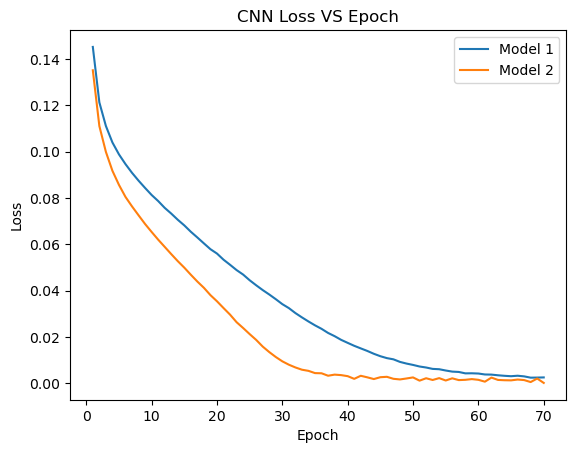

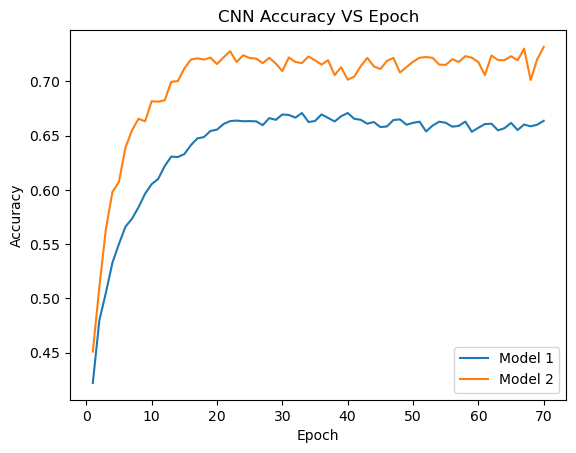

In [5]:
if __name__=='__main__':
    Epoch = 70

    model = my_cnn().to(device)
    epochs, loss_train, accuracy_train = Train_(model,Epoch)
    
    model1 = my_cnn1().to(device)
    epochs1, loss_train1, accuracy_train1 = Train_(model1,Epoch)
    
    plt.plot(epochs, loss_train, label='Model 1')
    plt.plot(epochs1, loss_train1, label='Model 2')
    plt.legend()
    plt.title('CNN Loss VS Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(epochs, accuracy_train, label='Model 1')
    plt.plot(epochs1, accuracy_train1, label='Model 2')
    plt.legend()
    plt.title('CNN Accuracy VS Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [6]:
# CIFAR10_classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# model = my_cnn()
# out = Test_(model,test_image)
# idx = torch.argmax(out,1)
# percent = nn.functional.softmax(out,dim=1)[0]*100
# print(CIFAR10_classes[idx], ':', percent[idx].item())